<a href="https://colab.research.google.com/github/nisharamanna555/ResponsibleDataScience/blob/main/lab_3_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Mitigating Bias Using Fairlearn**

Previously we explored bias metrics and measuring bias in a binary classification machine learning model. In this Lab we will continue working on the same data and ML model, this time using Fairlearn to perform bias-mitigating interventions in three different ways:

*   **Preprocessing interventions:** These algorithms transform the dataset (prior to training a model) in order to mitigate possible unfairness present in the data.
    - Example: One way to think about bias is as correlation between sensitive and non-sensitive features in the dataset. By applying the [CorrelationRemover](https://fairlearn.org/v0.7.0/api_reference/fairlearn.preprocessing.html#fairlearn.preprocessing.CorrelationRemover), these correlations are projected away while details from the original data are retained as much as possible (as measured by least-squares error). The user can control the level of projection via the `alpha` parameter.

*   **Reduction algorithms:** At a high level, the reduction algorithms within Fairlearn enable bias mitigation for machine learning models using user-provided constraints. The two available algorihtms are [Exponentiated Gradient](https://fairlearn.org/v0.7.0/api_reference/fairlearn.reductions.html#fairlearn.reductions.ExponentiatedGradient) and [Grid Search](https://fairlearn.org/v0.7.0/api_reference/fairlearn.reductions.html#fairlearn.reductions.GridSearch). The reductions approach seeks to reduce binary classification and regression problems subject to fairness contrains to a sequence of weighted classification problems. As a result, the reduction algorithms in Fairlearn only require a wrapper to access to any “base” learning algorithm. By this we mean that the “base” algorithm only needs to implement `fit` and `predict` methods (like any standard scikit-learn estimator) but it does not need to have any knowledge of the desired fairness constraints or sensitive features.

    From an API perspective this looks as follows in all situations:

  > reduction = Reduction(base_estimator, constraints, **kwargs)  
  > reduction.fit(X_train, y_train, sensitive_features=sensitive_features)  
  > reduction.predict(X_test)  

*   **Postprocessing algorithms:** The postprocessing algorithms transform the *outputs* of a classification or regression model to mitigate bias. For example, the [ThresholdOptimizer](https://fairlearn.org/v0.7.0/api_reference/fairlearn.postprocessing.html#fairlearn.postprocessing.ThresholdOptimizer) takes as input an existing classifier and the sensitive feature, and derives a monotone transformation of the classifier’s prediction to enforce the specified parity constraints.

This Lab is divided into the following parts:

1. Load the data as we did in Lab2;
2. Use preprocessing algorithms to mitigate bias;
3. Use reduction algorithms to mitigate bias;
4. Use postprocessing algorithms to mitigate bias.

#1. Load the data

If you have any doubts about Part 1, please refer to Lab 2, in which we did the same steps.

In [ ]:
# %%capture
#@markdown
!pip install fairlearn
!pip install folktables
!git clone https://github.com/lurosenb/superquail

fatal: destination path 'superquail' already exists and is not an empty directory.


In [ ]:
#@markdown Import statments
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics as skm

from fairlearn.datasets import fetch_adult
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

from IPython.display import clear_output

In [ ]:
#@markdown Import data
data, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=70000)

print(data.shape)
data.head()

(70000, 11)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,38.0,1.0,18.0,1.0,4600.0,6.0,0.0,6.0,2.0,1.0,0.0
1,49.0,1.0,18.0,1.0,9130.0,312.0,0.0,52.0,1.0,8.0,1.0
2,52.0,1.0,15.0,1.0,4000.0,303.0,0.0,40.0,1.0,8.0,0.0
3,58.0,1.0,19.0,1.0,4850.0,6.0,0.0,50.0,2.0,1.0,1.0
4,74.0,6.0,14.0,1.0,8025.0,247.0,0.0,40.0,1.0,6.0,0.0


In [ ]:
#@markdown Drop rows with missing values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  float64
 2   SCHL    70000 non-null  float64
 3   MAR     70000 non-null  float64
 4   OCCP    70000 non-null  float64
 5   POBP    70000 non-null  float64
 6   RELP    70000 non-null  float64
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  float64
 9   RAC1P   70000 non-null  float64
 10  PINCP   70000 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


In [ ]:
#@markdown Change data types of categorical features
numerical_cols = ['AGEP','WKHP']
categorical_cols = ['COW','SCHL','MAR','OCCP','POBP','RELP','RAC1P','SEX']

for col in categorical_cols:
  data[col] = data[col].astype('int')
  data[col] = data[col].astype('str')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  object 
 2   SCHL    70000 non-null  object 
 3   MAR     70000 non-null  object 
 4   OCCP    70000 non-null  object 
 5   POBP    70000 non-null  object 
 6   RELP    70000 non-null  object 
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  object 
 9   RAC1P   70000 non-null  object 
 10  PINCP   70000 non-null  float64
dtypes: float64(3), object(8)
memory usage: 5.9+ MB


In [ ]:
#@markdown Standardize numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,-0.322812,1,18,1,4600,6,0,-2.487606,2,1,0.0
1,0.415899,1,18,1,9130,312,0,1.097288,1,8,1.0
2,0.617366,1,15,1,4000,303,0,0.162098,1,8,0.0
3,1.020300,1,19,1,4850,6,0,0.941423,2,1,1.0
4,2.094789,6,14,1,8025,247,0,0.162098,1,6,0.0


In [ ]:
#@markdown One-hot encode categorical features
data = pd.get_dummies(data)

#since the sex attribute is already binary we can drop one of the redundant dummy columns
#note: males are now labeled as 1 and females are labeled as 0
data.drop(columns=['SEX_2'], inplace=True)
data.rename(columns={'SEX_1':'SEX'}, inplace=True)

data.head()

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,SEX,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9
0,-0.322812,-2.487606,0.0,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,0.415899,1.097288,1.0,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,0.617366,0.162098,0.0,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
3,1.020300,0.941423,1.0,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,2.094789,0.162098,0.0,False,False,False,False,False,True,False,...,True,False,False,False,False,False,True,False,False,False


In [ ]:
#@markdown Split data into training and test sets
target = data['PINCP']
data.drop(columns='PINCP', inplace=True)

#note: here we are setting a value for the random_state (seed) parameter so that the results of this lab will remain consistent
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=4)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (56000, 808)
y_train shape: (56000,)
X_test shape: (14000, 808)
y_test shape: (14000,)


Next, we will replicate our procedure from Lab 2 where we train a classifier and evaluate its accuracy and bias.

In [ ]:
#@markdown Implement logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)

clear_output()

print(f'Logistic Regression test accuracy: {clf_score:.4f}')

Logistic Regression test accuracy: 0.8203


In [ ]:
#@markdown Evaluate the fairness of the classifier using demographic_parity_difference and demographic_parity_ratio
#note: we are conducting this analysis over the test set

#compute test predictions
y_pred = clf.predict(X_test)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for males and females
male_selection_rate = selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
female_selection_rate = selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])

print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

Demographic parity difference: 0.1290
Demographic parity ratio: 0.7267
Male selection rate: 0.4720
Female selection rate: 0.3430


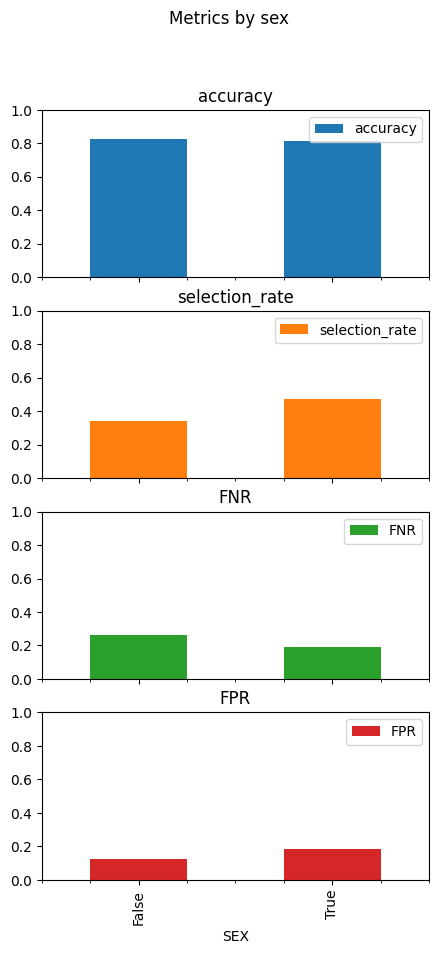

In [ ]:
#@markdown Evaluate (plot) the fairness of the classifier using the MetricFrame class

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature = X_test['SEX'].replace({0:'female', 1:'male'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

grouped_on_sex.by_group.plot.bar(
    subplots=True,
    figsize=(5, 10),
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()

As before, we see that there are some disparities in the selection rate, FPR, and FNR between males and females.

#2. Preprocessing algorithms

Here, we will use the Correlation Remover Preprocessing algorithm to attempt to mitigate bias in our model.  The Correlation Remover will modify the original data, and then we will use this modified data in place of our original data to train our predictive model.

Before implementing the correlation remover, let us take a look again at the correlations between the numeric features and the target variable.

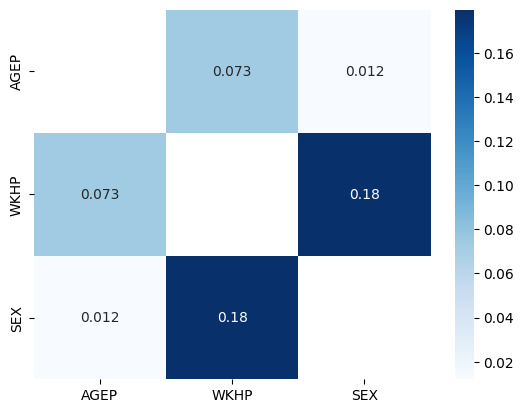

In [ ]:
#@markdown Plot pairwise correlations between numeric features
numerical_cols.append('SEX')
sn.heatmap(data[numerical_cols].corr(), mask=np.identity(len(data[numerical_cols].corr())), annot=True, cmap='Blues')
plt.show()

In [ ]:
#@markdown Implement Correlation Remover
column_names = list(data.columns.values)
column_names.remove("SEX")

cr = CorrelationRemover(sensitive_feature_ids=['SEX'], alpha=1.0)

data_cr = cr.fit_transform(data)
data_cr = pd.DataFrame(data_cr, columns=column_names, index=data.index)
data_cr["SEX"] = data["SEX"]

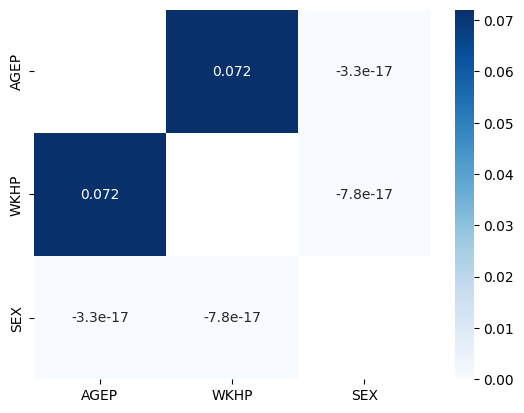

In [ ]:
#@markdown We can plot the pairwise correlation again to see if correlation with `SEX` has decreased

sn.heatmap(data_cr[numerical_cols].corr(), mask=np.identity(len(data_cr[numerical_cols].corr())), annot=True, cmap='Blues')
plt.show()

Here, using the modified data, we again implement our Logistic Regression classifier.

In [ ]:
#@markdown Split data into training and test sets
X_train_cr, X_test_cr, y_train_cr, y_test_cr = train_test_split(data_cr, target, test_size=0.2, random_state=4)

X_train_cr.drop(['SEX'], axis=1, inplace=True)
sens_feats = X_test_cr['SEX']
X_test_cr.drop(['SEX'], axis=1, inplace=True)

#implement logistic regression
clf = LogisticRegression()
clf.fit(X_train_cr, y_train_cr)
clf_score_cr = clf.score(X_test_cr, y_test_cr)

clear_output()

print(f'Logistic Regression with Correlation Remover test accuracy: {clf_score_cr:.4f}')

Logistic Regression with Correlation Remover test accuracy: 0.8156


### **Question 1:** Evaluate the fairness metrics of the model implemented with Correlation Remover (in terms of demographic parity difference, demographic parity ratio, male selection rate, female selection rate).

**Answer:**

In [ ]:
#compute test predictions
y_pred_cr = clf.predict(X_test_cr)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff_blind = demographic_parity_difference(y_test, y_pred_cr, sensitive_features=X_test['SEX'])
demo_parity_ratio_blind = demographic_parity_ratio(y_test, y_pred_cr, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference (without senstivie attribute): {demo_parity_diff_blind:.4f}')
print(f'Demographic parity ratio (without sensitive attribute): {demo_parity_ratio_blind:.4f}')

#compute selection rate for males and females
male_selection_rate_blind = selection_rate(y_test[X_test['SEX']==1], y_pred_cr[X_test['SEX']==1])
female_selection_rate_blind = selection_rate(y_test[X_test['SEX']==0], y_pred_cr[X_test['SEX']==0])

print(f'Male selection rate (without sensitive attribute): {male_selection_rate_blind:.4f}')
print(f'Female selection rate (without sensitive attribute): {female_selection_rate_blind:.4f}')

Demographic parity difference (without senstivie attribute): 0.0089
Demographic parity ratio (without sensitive attribute): 0.9786
Male selection rate (without sensitive attribute): 0.4153
Female selection rate (without sensitive attribute): 0.4064


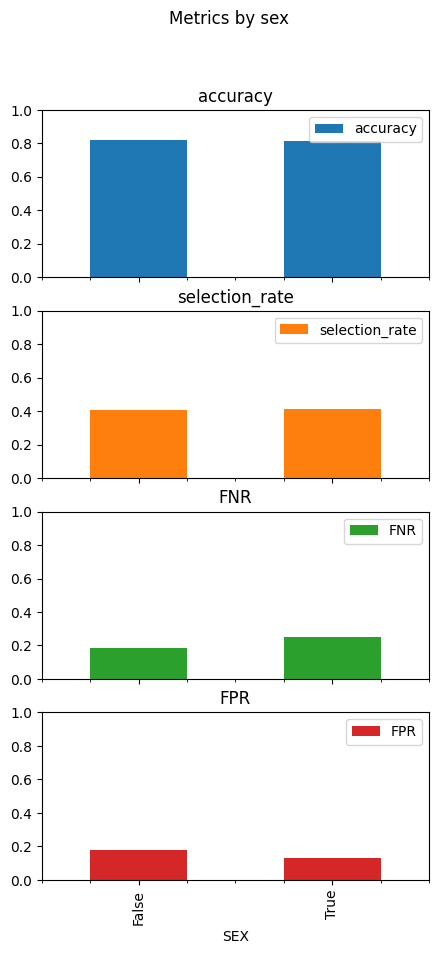

In [ ]:
#@title **Question 2:** Plot metrics using the MetricFrame class

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature = X_test['SEX'].replace({0:'female', 1:'male'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_cr,
                             sensitive_features=sensitive_feature)

grouped_on_sex.by_group.plot.bar(
    subplots=True,
    figsize=(5, 10),
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()

### **Question 3:** What are the main differences in terms of bias in the Logistic Regression model implemented before and after the Correlation Remover Pre-Processing algorithm? What do these results indicate in terms of the attributes' correlation with the feature "sex"?

**Answer here:** Selection rate evened out quite a bit. After applying the CorrelationRemover, women are selected "high income" on par with men. There is still a bit of a difference between the gender's FPR and FNR. However, the differences inversed- now, women have a lower FNR and a higher FPR.
This indicates that there was a correlation between attributes and the feature "sex" that was changed through the use of the Correlation Remover package. However, that correlation wasn't entirely linear and therefore the correlation removal process distorted the performance metrics.

### **Question 4:** What would we expect the results to be if we use an alpha parameter less than 1.0 (standard)? What would happen if we use alpha equal to 0?

**Answer here:** If we used an alpha parameter less than 1, more correlation between the feature sex and the related features would have remained. Therefore, the model still would've been biased against females. If we used alpha equal to 0, the data wouldn't have been changed at all. The selection rate, accuracy, FNR, and FPR would've been the same as before the correlation remover was applied.

#3. Reduction algorithms

Both **ExponentialGradient** and **GridSearch** can be used for binary classification and regression models, supporting the following fairness definitions:

*   **Demographic Parity:** ensures that the selection rate or percentage of samples with label = 1 is equal across all groups. Implicitly this means the percentage with label = 0 is equal as well.

*   **True Positive Rate Parity and False Positive Rate Parity:** ensures that the True Positive Rate (TP / TP + FN) **OR** the False Positive Rate (FP / FP + TN) is equal across all groups. In first case, we only have one event $Y = 1$ and ignore the samples with $Y = 0$, and in the second case vice versa.

*   **Equalized Odds:** ensures that both True Positive Rate (TP / TP + FN) **AND** the False Positive Rate (FP / FP + TN) are equal across all groups. The constraints represent the union of constraints for true positive rate and false positive rate. Thus, both events $Y = 1$ and $Y = 0$ are considered.

*   **Error Rate Parity:** ensures that the error rates should be the same across all groups. In this case, the utility is equal to 1 if $h(X) \neq Y$ and equal to 0 if $h(X) = Y$, and so large value of utility here actually correspond to poor outcomes.

*   **Control Features:** The above examples of Moment (Demographic Parity, True and False Positive Rate Parity, Equalized Odds and Error Rate Parity) all support the concept of control features when applying their fairness constraints. A control feature stratifies the dataset, and applies the fairness constraint within each stratum, but not between strata. One case this might be useful is a loan scenario, where we might want to apply a mitigation for the sensitive features while controlling for some other feature(s). This should be done with caution, since the control features may have a correlation with the sensitive features due to historical biases. In the loan scenario, we might choose to control for income level, on the grounds that higher income individuals are more likely to be able to repay a loan. However, due to historical bias, there is a correlation between the income level of individuals and their race and gender.

##3.1 GridSearch

Here, we will implement the Grid Search intervention on our classifier and examine its effects on bias in our model.  GridSearch implements a simplified version of the [exponentiated gradient reduction](https://fairlearn.org/main/api_reference/generated/fairlearn.reductions.ExponentiatedGradient.html) intervention.  It works by generating a sequence of relabellings and reweightings and trains a predictor for each.  From there, users can select the model that generates the most favorable tradoff between accuracy and fairness for their specific purpose.

In [ ]:
#first we specificy Demographic Parity as our fairness metric and generate a train a series of predictors
sweep = GridSearch(LogisticRegression(max_iter=100), constraints=DemographicParity())

sweep.fit(X_train, y_train, sensitive_features=X_train['SEX'])

predictors = sweep.predictors_

#next, we remove predictors which are dominated in the error-disparity space by others from the sweep
errors, disparities = [], []
for m in predictors:
    def classifier(X): return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, y_train, sensitive_features=X_train['SEX'])
    disparity = DemographicParity()
    disparity.load_data(X_train, y_train, sensitive_features=X_train['SEX'])

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][all_results["disparity"] <= row.disparity]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

clear_output()

In [ ]:
#here we calculate the accuracy and fairness metrics for our dominant models
model_num = []
accuracy_gs = []
demo_parity_diff_gs = []
demo_parity_ratio_gs = []
male_selection_rate_gs = []
female_selection_rate_gs = []

for i in range(len(non_dominated)):
    y_pred = non_dominated[i].predict(X_test)

    model_num.append("dominant_model_{0}".format(i))
    accuracy_gs.append(accuracy_score(y_test,y_pred))
    demo_parity_diff_gs.append(demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX']))
    demo_parity_ratio_gs.append(demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX']))
    male_selection_rate_gs.append(selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1]))
    female_selection_rate_gs.append(selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0]))


grid_search_results_df = pd.DataFrame()
grid_search_results_df['model'] = model_num
grid_search_results_df['accuracy'] = accuracy_gs
grid_search_results_df['demo_parity_diff'] = demo_parity_diff_gs
grid_search_results_df['demo_parity_ratio'] = demo_parity_ratio_gs
grid_search_results_df['male_selection_rate'] = male_selection_rate_gs
grid_search_results_df['female_selection_rate'] = female_selection_rate_gs

grid_search_results_df

,model,accuracy,demo_parity_diff,demo_parity_ratio,male_selection_rate,female_selection_rate
0,dominant_model_0,0.794786,0.126686,0.737384,0.355714,0.482400
1,dominant_model_1,0.820286,0.128992,0.726707,0.471990,0.342999


### **Question 5:** If we decide to prioritize fairness over accuracy in our model, which of these models would you select and why? Recreate the MetricFrame plots used previously for the selected model.

**Note: Results may changes with different runs.**


**Answer here:** I would choose "dominant_model_0". The accuracy was slight lower but it had a better demographic parity difference and ratio.

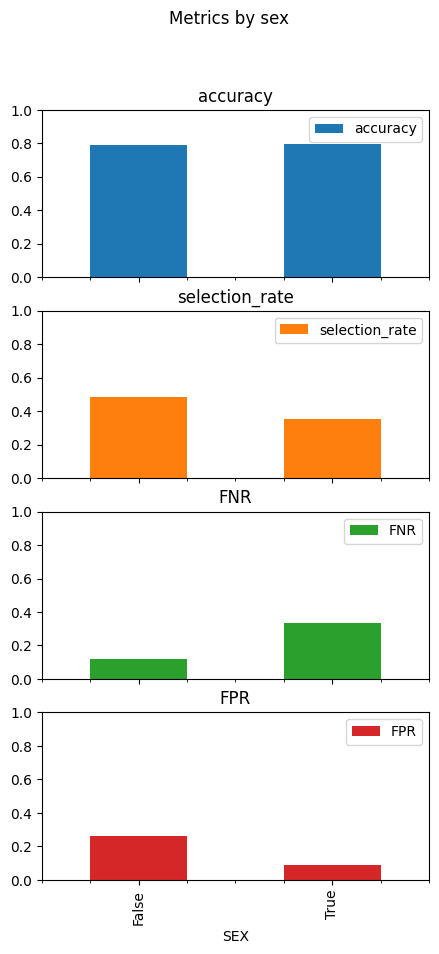

In [ ]:
#@markdown Plot the fairness metrics of the selected classifier using the MetricFrame class
selected_model_num = 0
y_pred_gs = non_dominated[selected_model_num].predict(X_test)

grouped_on_sex_grid_search = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_gs,
                             sensitive_features=sensitive_feature)
#plot the metric values
grouped_on_sex_grid_search.by_group.plot.bar(
    subplots=True,
    figsize=(5, 10),
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()

### **Question 6:** What does a comparison of these models tell us about the relationship between accuracy and fairness in our models?

**Answer here:** It tells us that often, improving fairness requires a decrease in accuracy.

# 4 Postprocessing algorithms

As mentioned above, postprocessing algorithms transform the *outputs* of a classification or regression model to mitigate bias. Below, we'll use the [ThresholdOptimizer](https://fairlearn.org/v0.7.0/api_reference/fairlearn.postprocessing.html#fairlearn.postprocessing.ThresholdOptimizer), which takes as input an existing classifier and the sensitive feature, and derives a monotone transformation of the classifier’s prediction to enforce the specified parity constraints.

### Question 7: Write code below to train a ThresholdOptimizer with FNR parity and plot the same metrics used above after the intervention. You can use `selection_rate_parity` as the constraint and `balanced_accuracy_score` as the objective. Is the ThresholdOptimizer successful at balancing selection rates? Plot your MetricFrame results. [Hint: look at the ThresholdOptimizer documentation linked above.]

In [ ]:
sensitive_features_train = X_train['SEX'].replace({0:'female', 1:'male'})
sensitive_features_test = X_test['SEX'].replace({0:'female', 1:'male'})

# classification task -> Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

threshold_optimizer = ThresholdOptimizer(
    estimator=clf,
    constraints="selection_rate_parity",
    objective='balanced_accuracy_score',
)
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_features_train)

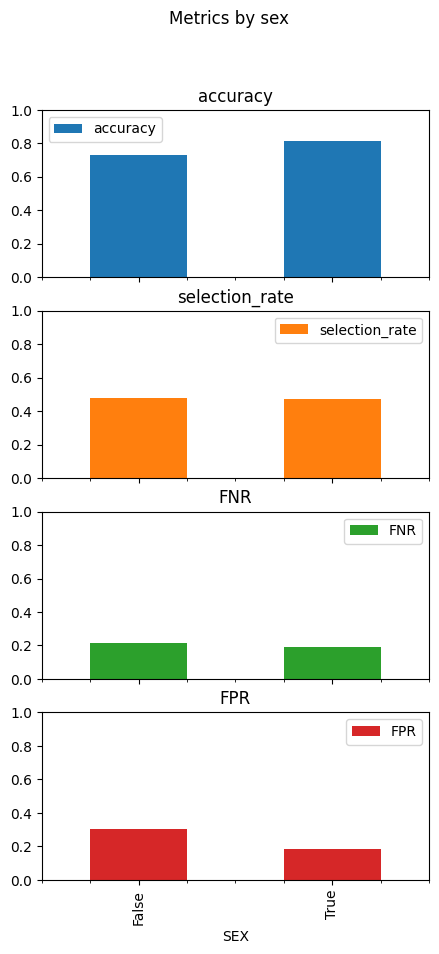

In [ ]:
#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature = X_test['SEX'].replace({0:'female', 1:'male'})

y_pred_to = threshold_optimizer.predict(X_test, sensitive_features=sensitive_feature)

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_to,
                             sensitive_features=sensitive_feature)

grouped_on_sex.by_group.plot.bar(
    subplots=True,
    figsize=(5, 10),
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()

/usr/local/lib/python3.10/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:288: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


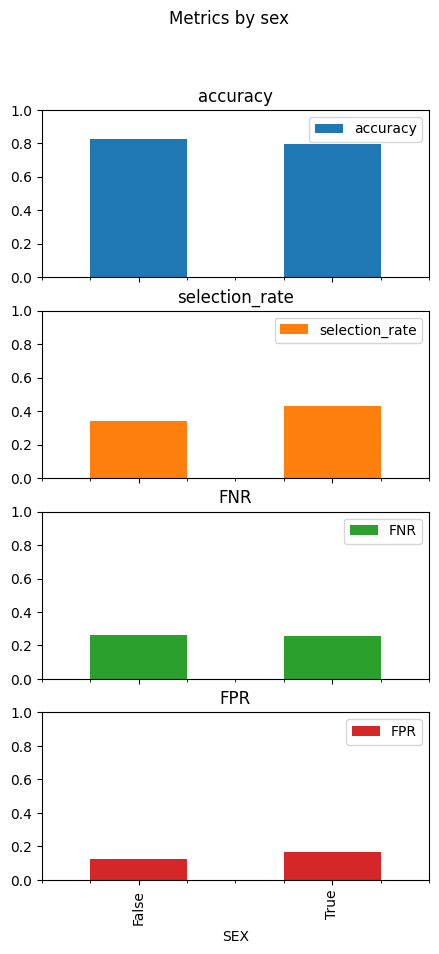

In [ ]:
#@title Question 8: Now try the ThresholdOptimizer with `false_negative_rate_parity` instead of `selection_rate_parity` and plot the same MetricFrame results.

# classification task -> Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

threshold_optimizer = ThresholdOptimizer(
    estimator=clf,
    constraints="false_negative_rate_parity",
    objective='balanced_accuracy_score',
)
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_features_train)

y_pred_to = threshold_optimizer.predict(X_test, sensitive_features=sensitive_feature)

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred_to,
                             sensitive_features=sensitive_feature)

grouped_on_sex.by_group.plot.bar(
    subplots=True,
    figsize=(5, 10),
    ylim=[0,1],
    title="Metrics by sex",
    )
plt.show()

### Question 9: Which of all the methods we tried in this lab was the most effective?

**Answer here:** I think the threshold optimizer was the most effective method we tried. Especially when we used selection rate parity as the constraint. It was able to maintain a high accuracy while balancing selection rate, FNR, and FPR.